# Tackle the MNIST data set and select best model for digit recognition 
 

Kaggle final position : 1581 with KNN model and 1435 with SVC


## A. Run Binary classifier and illustrate several models with ROC, Precision-Recall

## B. We want to build a pipeline in order to transform the data, scaling the data and do feature ingineering

## C. Will run the prediction for the test set from Kaggle competition

## D. Let's try with SVM and Gaussian / Polynomial Kernel

## E. Will RE-run the prediction for the test set from Kaggle competition, using SVM instead of KNN


 Sources:

  - "Hands on machine learning with scikit learn and TensorFlow", Aurelien Geron
    
    
#### Introduction :

This Notebook will concentrate on the functions available in Scikit learn only. We won't try to use Deep Learning methods as it can be to challenging in terms of speed for our machine.

Our objective is to climb the ladders in the Kaggle competition, as we relaized that we are only in the 1581 position  by using KNN model, with prediction of about 97.5%. In this Notebook, we are motivated from the Machine Learning Course of Andrew Ng, as we know that SVM is performing as well as Neural Network for hand written digit recognition, so we should be able to get accuracy at around 98-99% if we manage to find the correct parameters for the SVM model.

Sections A, B focus on preliminary analysis of 2 class binary classification models, and put in place a pipeline to pre-process the data. 
Section C will use the best model for recognizing 0 to 9 digits and run the test dataset of the Kaggle competition.
Section D and E tries to improve accuracy score by using Support Vector Classifier, and tries to give intuition on how to chose Kernels and Tuning parameters.

We faced some problems in computing time when tuning hyper-parameters. We found the solution in Aurelion Geron Notebooks, by doing 1st tuning with smaller dataset with RandomSearchCV. Then we can have a better idea where are the best parameters ranges. After we can fined tune by looking in smaller range with the entire dataset, and find the final and best parameters. 



In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

import seaborn as sns
import cmath

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from __future__ import division
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
#warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings('ignore')

In [2]:
# Retreive data from csv file
train = pd.read_csv('train.csv',sep=',')

In [3]:
# define Training set and target
X , y = train.drop('label',axis=1) , train['label']
# Let's check the size of our training set
X.shape

(42000, 784)

In [4]:
# We will split half of the data for the training and half for the test
X_train, X_test, y_train, y_test = X[:35000] , X[35000:], y[:35000], y[35000:]

# Shuffle data
shuffle_index = np.random.permutation(35000)
X_train, y_train = X_train.values[shuffle_index], y_train[shuffle_index]

## A. Run Binary classifier and illustrate several models with ROC, Precision-Recall

In [5]:
# Let's try a model on only 1 number , let's use 6
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

In [6]:
# Let's try with Stochastic Gradient Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_6)

some_digit = X.values[2000]

sgd_clf.predict([some_digit])

array([False])

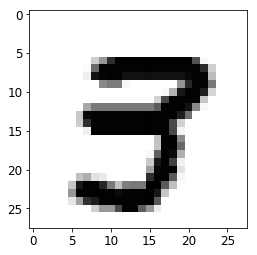

In [7]:
plt.imshow(some_digit.reshape(28,28),cmap = matplotlib.cm.binary, interpolation = 'nearest')
#plt.axis("off")
plt.show()

In [8]:
# We know that loss hinge will use Linear classifier
sgd_clf.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)>

In [9]:
# Let's use cross validation function to evaluate your SGDClassifier on for the digit 6
from sklearn.model_selection import cross_val_score
cross_val_score( sgd_clf, X_train, y_train_6, cv=3, scoring='accuracy')


array([0.9790006 , 0.97771492, 0.98199897])

In [10]:
# We create our Class for the digit 6
from sklearn.base import BaseEstimator

class Never6Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

Never_6_cf = Never6Classifier()
cross_val_score( Never_6_cf, X_train, y_train_6, cv=3, scoring='accuracy')


array([0.9036599 , 0.90100283, 0.9016801 ])

In [11]:
from sklearn.model_selection import cross_val_predict

# The function cross_val_predict has a similar interface to cross_val_score, but returns, 
# for each element in the input, the prediction that was obtained for that element when it was in the test set.
# Only cross-validation strategies that assign all elements to a test set exactly once can be used 
# (otherwise, an exception is raised)

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6,y_train_pred)


array([[31255,   319],
       [  396,  3030]], dtype=int64)

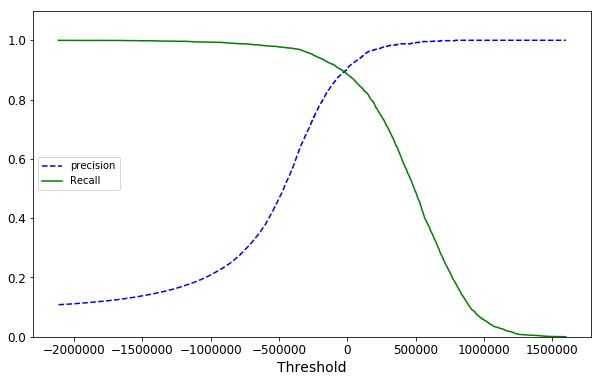

In [12]:
# Let's now print the ROC and Precision-Recall curve to see the performance of Classification algorithm
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig = plt.figure(figsize=(10, 6))
    fig.clf()
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1],"g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1.1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

No handles with labels found to put in legend.


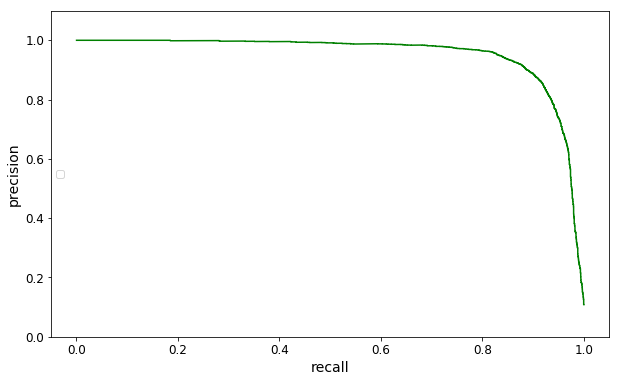

In [13]:
def plot_precision_vs_recall(precisions, recalls, thresholds):
    fig = plt.figure(figsize=(10, 6))
    fig.clf()
    plt.plot(recalls[:-1], precisions[:-1], "g-")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="center left")
    plt.ylim([0,1.1])
    
plot_precision_vs_recall(precisions, recalls, thresholds)
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score

y_pred_90 = (y_scores>120000)

# What is the recall for precision at 90%
recall_score(y_train_pred,y_pred_90)

0.8975813675724097

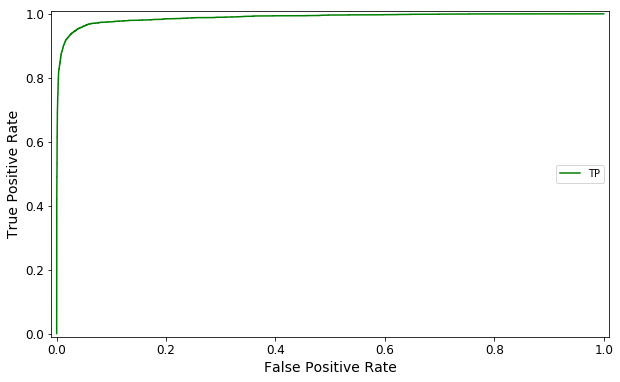

In [15]:
# We plot the ROC curve which gives additional info on the performance than precision / recall
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_6, y_scores)

def plot_roc_curve(fpr, tpr, label):
    #plt.plot([0,1],[0,1], "b--", label="Random guess")
    plt.plot(fpr, tpr,"g-", label=label)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="center right")
    plt.ylim([-0.01,1.01])
    plt.xlim([-0.01,1.01])
    
fig = plt.figure(figsize=(10, 6))
fig.clf()
    
plot_roc_curve(fpr, tpr, "TP")
plt.show()


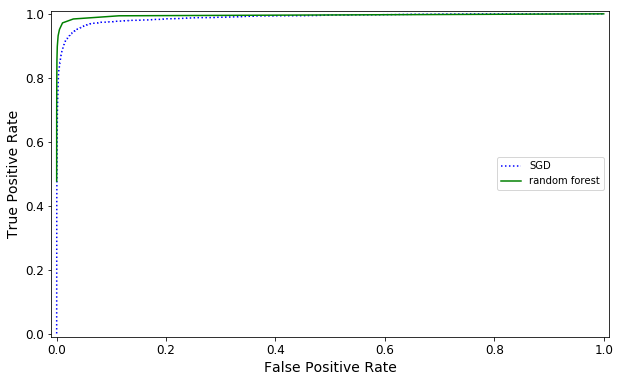

In [16]:
# Now let's compare Linear with Random Forest
from sklearn.ensemble import RandomForestClassifier

rdnm_fst = RandomForestClassifier(random_state=10)

y_scores_rdnm = cross_val_predict(rdnm_fst, X_train, y_train_6, cv=3, method="predict_proba")
#precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

fpr_rdnm, tpr_rdnm, thresholds_rdnm = roc_curve(y_train_6, y_scores_rdnm[:,1])

fig = plt.figure(figsize=(10, 6))
fig.clf()

plt.plot(fpr, tpr,"b:", label="SGD")
plot_roc_curve(fpr_rdnm, tpr_rdnm,"random forest")
plt.show()

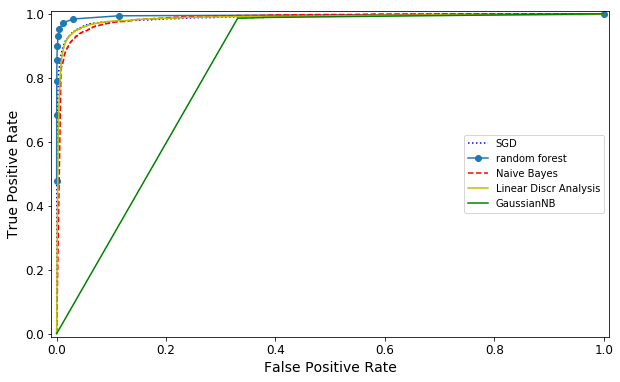

In [17]:
# We can see that the RandomForest classifier does better than the Stochastic
# We can also add Multinomial, Linear Discriminant Analysis and Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

svc_fst = GaussianNB()
svc_brn = BernoulliNB()
svc_lda = LinearDiscriminantAnalysis()

y_scores_svc = cross_val_predict(svc_fst, X_train, y_train_6, cv=3, method="predict_proba")
y_scores_brn = cross_val_predict(svc_brn, X_train, y_train_6, cv=3, method="predict_proba")
y_scores_lda = cross_val_predict(svc_lda, X_train, y_train_6, cv=3, method="predict_proba")
#precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train_6, y_scores_svc[:,1])
fpr_brn, tpr_brn, thresholds_brn = roc_curve(y_train_6, y_scores_brn[:,1])
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_train_6, y_scores_lda[:,1])

fig = plt.figure(figsize=(10, 6))
fig.clf()

plt.plot(fpr, tpr,"b:", label="SGD")
plt.plot(fpr_rdnm, tpr_rdnm,"-o", label="random forest")
plt.plot(fpr_brn, tpr_brn,"r--", label="Naive Bayes")
plt.plot(fpr_lda, tpr_lda,"y-", label="Linear Discr Analysis")
plot_roc_curve(fpr_svc, tpr_svc,"GaussianNB")
plt.show()


In [18]:
# The air below the ROC curve is the AUC and also tells about overall performance
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_6,y_scores_rdnm[:,1])

0.9952414718547199

In [19]:
# We get 99.5% AUC score , it's amazing
# We now study the Multiclass model, using default system OvA ( better for large training sets )
sgd_clf.fit(X_train, y_train)
# Let's now look at overall target, not only the number 6 but all
cross_val_score( sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.81285347, 0.79161666, 0.8542524 ])

In [20]:
# We will add a scaler to the set to improve our performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score( sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90882605, 0.9079376 , 0.90526406])

We have improved score by 3% by scaling, it is worth doing feature engineering

## B. We want to build a pipeline in order to transform the data, scaling the data and do feature ingeneering

### 1) Multinomial or Softmax Classifier

In [21]:
Multinomial = SGDClassifier(loss='log')
cross_val_score( Multinomial, X_train, y_train, cv=3, scoring='accuracy')

array([0.87686375, 0.86207783, 0.86582647])

In [22]:
cross_val_score( Multinomial, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91062554, 0.90716612, 0.905607  ])

In [23]:
# Now let's built the training set with more data by moving up and down the images
# We define 4 different functions and create a Class with fit_transform method to 
# include in the pipeline

from sklearn.base import TransformerMixin 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

def down(X_train,delta):
    shifted = []    
    for digit in X_train:
        digit = DataFrame(digit.reshape(28,28)).shift(delta).fillna(0)        
        shifted.append(digit.values.flatten())
    return np.array(shifted)


def up(X_train,delta):
    shifted = []    
    for digit in X_train:
        digit = DataFrame(digit.reshape(28,28)).shift(-delta).fillna(0)        
        shifted.append(digit.values.flatten())
    return np.array(shifted)

def left(X_train,delta):
    shifted = []    
    for digit in X_train:
        digit = DataFrame(digit.reshape(28,28)).shift(-delta,axis=1).fillna(0)        
        shifted.append(digit.values.flatten())
    return np.array(shifted)


def right(X_train,delta):
    shifted = []    
    for digit in X_train:
        digit = DataFrame(digit.reshape(28,28)).shift(delta,axis=1).fillna(0)        
        shifted.append(digit.values.flatten())
    return np.array(shifted)


class Add_shifted_train(BaseEstimator, TransformerMixin):
    """Transform or add new"""
    def __init__(self,delta):
        self.delta = delta
        
    def fit(self, X_train, y=None):
        return self

    def transform(self, X_train):
        X_down = down(X_train,self.delta)
        X_up = up(X_train,self.delta)
        X_left = left(X_train,self.delta)
        X_right = right(X_train,self.delta)
        return np.concatenate((X_train,X_down,X_up,X_left,X_right),axis=0)
    
# We create 1 instance of the class to use later in the pipeline
x_train_and_shift = Add_shifted_train(1)

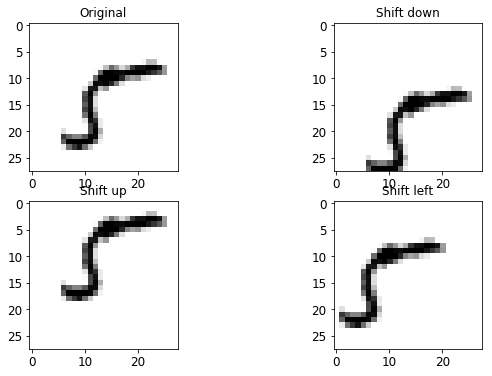

In [24]:
# We plot an example digit which has been shifted up, down, right and left
fig = plt.figure(figsize=(10, 6))
fig.clf()

some_digit = X_train[2000]

plt.subplot(221);plt.imshow(some_digit.reshape(28,28),cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.title('Original')
plt.subplot(222);plt.imshow(down(X_train,5)[2000].reshape(28,28),cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.title('Shift down')
plt.subplot(223);plt.imshow(up(X_train,5)[2000].reshape(28,28),cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.title('Shift up')
plt.subplot(224);plt.imshow(left(X_train,5)[2000].reshape(28,28),cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.title('Shift left')

plt.show()

### 2) Random Forest Classifier

In [25]:
full_pipeline_with_shift = Pipeline([
    ('shift', Add_shifted_train(1)),
    ('scaler',StandardScaler()),
])

y = np.concatenate((y_train,y_train,y_train,y_train,y_train),axis=0)

X_train_prep = full_pipeline_with_shift.fit_transform(X_train)

In [26]:
rdm = RandomForestClassifier(random_state=10)

cross_val_score( rdm, X_train_prep, y, cv=3, scoring='accuracy')

array([0.95061369, 0.90744677, 0.93195611])

In [27]:
# Will grid search best params of our model
rdm = RandomForestClassifier()

param_distribs = {
        'n_estimators': [5,10,30],
    }

grid_search = GridSearchCV(rdm, param_grid=param_distribs,
                                cv=5, scoring='accuracy')
grid_search.fit(X_train_prep, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 30]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [28]:
scores = grid_search.best_score_

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", grid_search.cv_results_['mean_score_time'].mean())
    print("Standard deviation:", grid_search.cv_results_['mean_score_time'].std())
    print("Best params:", grid_search.best_params_)
    
display_scores_params(scores)

Scores: 0.7822457142857143
Mean: 0.32745952606201173
Standard deviation: 0.1675787893390307
Best params: {'n_estimators': 30}


### 3) Confusion matrix of our model

In [29]:
# We choose the Multinomial model
y_train_pred = cross_val_predict(Multinomial, X_train_prep, y, cv=3)

df_confusion_matrix = DataFrame(confusion_matrix(y,y_train_pred), index = np.arange(10), columns = np.arange(10))

df_confusion_matrix.columns.name = 'Predicted'
df_confusion_matrix.index.name = 'Actual'

df_confusion_matrix

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,16131,8,58,77,27,283,192,26,242,36
1,2,17692,160,398,12,181,25,464,553,28
2,170,127,15071,320,374,113,422,245,602,86
3,191,173,527,14867,24,912,176,179,746,315
4,96,74,188,74,14475,63,256,89,586,934
5,281,155,143,848,268,12732,439,83,764,262
6,190,171,211,73,576,333,14914,132,239,291
7,127,147,342,163,219,113,32,16055,385,827
8,189,495,141,728,44,673,153,102,13970,385


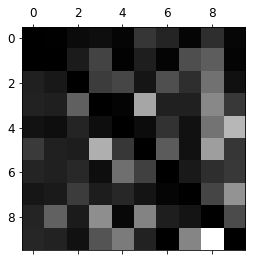

In [30]:
# Or we can look at errors
row_sums = confusion_matrix(y,y_train_pred).sum(axis=1,keepdims=True)

norm_conf_mx = confusion_matrix(y,y_train_pred) / row_sums

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

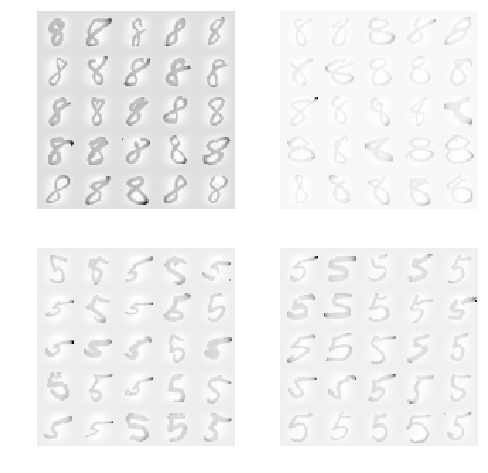

In [31]:
# Seems that 8 is very often predicted as 3's 
cl_a, cl_b = 8,5
X_aa = X_train_prep[(y == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train_prep[(y == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train_prep[(y == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train_prep[(y == cl_b) & (y_train_pred == cl_b)]


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(8,8))

plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)
plt.show()


### 3) And the KNearestNeighbor

In [29]:
# Question 1) Build a Classifier which have more than 97% accuracy
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()

cross_val_score( KNN, X_train, y, cv=3, scoring='accuracy')

array([0.95376783, 0.93189221, 0.93673924])

In [23]:
# I should run the grid search to find the best hyperparameters but it took me 20 hours to run 3 CV 
# with above model, so it will be too long to run 3 * 5 combinations with each 5 CV

# Will grid search best params of our pipeline

#param_distribs = {
#        'n_neighbors': [3,4,10],
#        'weights': ['uniform','distance'],
#        'n_jobs':[-1]
#    }

#grid_search = GridSearchCV(full_pipeline_with_shift, param_grid=param_distribs,
#                                cv=5, scoring='accuracy')
#grid_search.fit(X_train, y)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

# We should have obtained 4 neighbors as the best parameters for the model, and uniform as weight, which is the default para
KNN = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=5)

X_train_augmented = Add_shifted_train(1).fit_transform(X_train)

KNN.fit(X_train_augmented, y)

# We should run again a cross validation to be sure that we get a correct value for the score
# But as we explained before, it would take too long and until I find a better computer
# so we will calculate the training score, knowing that we get a biaised results.
# Since the scores on the previous 3 CV were higher than for all the other model, we trust
# this model is outperforming


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='distance')

In [37]:
from sklearn.metrics import accuracy_score
y_knn_pred = KNN.predict(X_test)

accuracy_score(y_test, y_knn_pred)

0.9758571428571429

## C. Will run the prediction for the test set from Kaggle competition

In [39]:
# Retreive data from csv file
test = pd.read_csv('test.csv',sep=',')

kaggle_pred = KNN.predict(test)

results = pd.DataFrame({
    'ImageID': pd.Series(range(1,28001)),
    'Label' : kaggle_pred,
})

results.to_csv("test.csv", index=False)

## D. Let's try with SVM and Gaussian / Polynomial Kernel

####    1) Polynomial : Pre-processing and SVC

In [49]:
from sklearn.svm import SVC

# We now pre-process data by adding Polynomial degree number 3
full_pipeline_with_svc = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler',StandardScaler()),
    #('svm',SGDClassifier(loss='hinge', alpha = 1/(m*10))),
])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
param_distribs = {
        'poly_features__degree': [3],
    }


grid_search = GridSearchCV(full_pipeline_with_svc,param_grid=param_distribs,
                                cv=2, scoring='accuracy', verbose=2)

grid_search.fit(X_train_augmented[1:10], y[1:10])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] poly_features__degree=3 .........................................
[CV] .......................... poly_features__degree=3, total=32.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 48.3min remaining:    0.0s


[CV] poly_features__degree=3 .........................................
[CV] .......................... poly_features__degree=3, total=35.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 101.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SGDClassifier(alpha=0.00012755102040816328, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=T...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'poly_features__degree': [3]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

We conclude here that the timing is much too long for training only 10 training examples, with total of almost 3 hours. This is not the best way to apply polynomial Kernel before running SVC.

In the following section, we use Polynomial Kernel from the SVC method directly, to see if runs faster.

In [25]:
# We need to transform the X matrix before
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

X_train_augmented = Add_shifted_train(1).fit_transform(X_train)
X_stacked = matrix_transf().fit_transform(X_train)

m = X_stacked.shape[1]

full_pipeline_with_svc = Pipeline([
    #('poly_features', PolynomialFeatures(degree=3)),
    ('scaler',StandardScaler()),
    ('svc',SVC()),
    #('svm',SGDClassifier(loss='hinge', alpha = 1/(m*10))),
])

param_distribs = {
        'svc__degree': [3],
        'svc__kernel':['poly'],
        'svc__C': [0.001,1.0,10000],
    }

full_pipeline_with_svc.get_params()

In [35]:
y = np.concatenate((y_train,y_train,y_train,y_train,y_train),axis=0)

grid_search = GridSearchCV(full_pipeline_with_svc,param_grid=param_distribs,
                                cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_stacked, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] svc__C=0.001, svc__degree=3, svc__kernel=poly ...................
[CV] .... svc__C=0.001, svc__degree=3, svc__kernel=poly, total= 2.0min
[CV] svc__C=0.001, svc__degree=3, svc__kernel=poly ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] .... svc__C=0.001, svc__degree=3, svc__kernel=poly, total= 1.7min
[CV] svc__C=0.001, svc__degree=3, svc__kernel=poly ...................
[CV] .... svc__C=0.001, svc__degree=3, svc__kernel=poly, total= 1.6min
[CV] svc__C=0.001, svc__degree=3, svc__kernel=poly ...................
[CV] .... svc__C=0.001, svc__degree=3, svc__kernel=poly, total= 1.8min
[CV] svc__C=0.001, svc__degree=3, svc__kernel=poly ...................
[CV] .... svc__C=0.001, svc__degree=3, svc__kernel=poly, total= 1.7min
[CV] svc__C=1.0, svc__degree=3, svc__kernel=poly .....................
[CV] ...... svc__C=1.0, svc__degree=3, svc__kernel=poly, total=  24.0s
[CV] svc__C=1.0, svc__degree=3, svc__kernel=poly .....................
[CV] ...... svc__C=1.0, svc__degree=3, svc__kernel=poly, total=  24.4s
[CV] svc__C=1.0, svc__degree=3, svc__kernel=poly .....................
[CV] ...... svc__C=1.0, svc__degree=3, svc__kernel=poly, total=  27.5s
[CV] svc__C=1.0, svc__degree=3, svc__kernel=poly .....................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 144.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc__degree': [3], 'svc__kernel': ['poly'], 'svc__C': [0.001, 1.0, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [38]:
# We look at the scores result and see if we get accuracy at least above 90%
scores = grid_search.best_score_

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", grid_search.cv_results_['mean_score_time'].mean())
    print("Standard deviation:", grid_search.cv_results_['mean_score_time'].std())
    print("Best params:", grid_search.best_params_)
    
display_scores_params(scores)

Scores: 0.8254285714285714
Mean: 5.691287469863891
Standard deviation: 1.9308838189186108
Best params: {'svc__C': 10000, 'svc__degree': 3, 'svc__kernel': 'poly'}


So we deduct that 82% as best score for polynomial transformation is not sattisfying. We should run a Grida search for wider parameter range, for polynomial degree and C as we should see better accuracy. Nonetheless, we will continue with Gaussian Kernel as we could see better result and cheaper

####    2) Gaussian : Tuning hyperparameters C and Gamma

In [26]:
# With Random search we will try to find the best params
# To start we need to find how to search for the best 
# hyper parameters of C and Gamma of the SVC classifier
# For that we will run random search with a few training\
# examples. ( and in order to save time)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

pipeline_pre = Pipeline([
    #('poly_features', PolynomialFeatures(degree=3)),
    ('scaler',StandardScaler()),
    ('shift', Add_shifted_train(1)),
    
])


X = pipeline_pre.fit_transform(X_train)

In [68]:
# We will chose values of C randomly from different ranges and narrow the range step by step
# For tweaking gamma, we will change ranges, but use distribution of reciprocal discibuted exponentially

param_distribs = {
        'C': uniform(1, 10),
        'gamma': reciprocal(0.001, 0.1),
    }


svc = SVC()

rdn_search = RandomizedSearchCV(svc,param_distribs, cv=5, n_iter=10,scoring='accuracy', verbose=2)

rdn_search.fit(X[:1000], y[:1000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=8.415502205479687, gamma=0.017486313873340997 .................
[CV] .. C=8.415502205479687, gamma=0.017486313873340997, total=   1.3s
[CV] C=8.415502205479687, gamma=0.017486313873340997 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] .. C=8.415502205479687, gamma=0.017486313873340997, total=   1.3s
[CV] C=8.415502205479687, gamma=0.017486313873340997 .................
[CV] .. C=8.415502205479687, gamma=0.017486313873340997, total=   1.3s
[CV] C=8.415502205479687, gamma=0.017486313873340997 .................
[CV] .. C=8.415502205479687, gamma=0.017486313873340997, total=   1.3s
[CV] C=8.415502205479687, gamma=0.017486313873340997 .................
[CV] .. C=8.415502205479687, gamma=0.017486313873340997, total=   1.4s
[CV] C=9.782810242382771, gamma=0.048413162660174654 .................
[CV] .. C=9.782810242382771, gamma=0.048413162660174654, total=   1.3s
[CV] C=9.782810242382771, gamma=0.048413162660174654 .................
[CV] .. C=9.782810242382771, gamma=0.048413162660174654, total=   1.4s
[CV] C=9.782810242382771, gamma=0.048413162660174654 .................
[CV] .. C=9.782810242382771, gamma=0.048413162660174654, total=   1.4s
[CV] C=9.782810242382771, gamma=0.048413162660174654 .................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20DD5FB38>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20DD5F668>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [69]:
DataFrame(rdn_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.274071,0.169740,0.399,1.0,8.4155,0.0174863,"{'C': 8.415502205479687, 'gamma': 0.0174863138...",6,0.346341,1.0,...,0.395,1.0,0.454545,1.0,0.379487,1.0,0.008863,0.003094,0.036779,0.0
1,1.320910,0.180889,0.196,1.0,9.78281,0.0484132,"{'C': 9.782810242382771, 'gamma': 0.0484131626...",8,0.195122,1.0,...,0.190,1.0,0.186869,1.0,0.205128,1.0,0.051212,0.004581,0.007066,0.0
2,1.293718,0.169341,0.766,1.0,5.95943,0.00516791,"{'C': 5.9594314373024995, 'gamma': 0.005167913...",5,0.726829,1.0,...,0.760,1.0,0.823232,1.0,0.784615,1.0,0.105043,0.006517,0.034649,0.0
3,0.940283,0.148667,0.872,1.0,5.46341,0.00154987,"{'C': 5.463408154307967, 'gamma': 0.0015498744...",1,0.839024,1.0,...,0.865,1.0,0.914141,1.0,0.897436,1.0,0.048245,0.005988,0.029009,0.0
4,1.204374,0.161550,0.796,1.0,9.84078,0.00424087,"{'C': 9.84077735126501, 'gamma': 0.00424086732...",4,0.751220,1.0,...,0.785,1.0,0.843434,1.0,0.815385,1.0,0.071149,0.000570,0.031144,0.0
5,1.299693,0.177641,0.196,1.0,5.54899,0.0477759,"{'C': 5.5489917537131594, 'gamma': 0.047775910...",8,0.195122,1.0,...,0.190,1.0,0.186869,1.0,0.205128,1.0,0.036129,0.004330,0.007066,0.0
6,1.068762,0.155053,0.836,1.0,6.89599,0.00300964,"{'C': 6.895994496828961, 'gamma': 0.0030096356...",2,0.800000,1.0,...,0.830,1.0,0.873737,1.0,0.841026,1.0,0.010964,0.004554,0.023661,0.0
7,1.121702,0.158992,0.818,1.0,3.87734,0.00367884,"{'C': 3.8773399857662243, 'gamma': 0.003678838...",3,0.785366,1.0,...,0.810,1.0,0.858586,1.0,0.825641,1.0,0.018193,0.006540,0.024005,0.0
8,1.336792,0.183907,0.194,1.0,9.13306,0.0551341,"{'C': 9.133059494520879, 'gamma': 0.0551341424...",10,0.195122,1.0,...,0.190,1.0,0.181818,1.0,0.205128,1.0,0.029302,0.007013,0.007762,0.0
9,1.334691,0.176645,0.198,1.0,10.6257,0.0419276,"{'C': 10.625710158407882, 'gamma': 0.041927633...",7,0.200000,1.0,...,0.190,1.0,0.186869,1.0,0.210256,1.0,0.031376,0.002233,0.008511,0.0


In [70]:
rdn_search.best_estimator_

SVC(C=5.463408154307967, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0015498744701773304,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [71]:
rdn_search.best_score_

0.872

This score will be a first benchmark to check a wide range for C and Gamma parameters

Now we will check if by increasing C we can improve substantially the score with only 1000 training set

In [65]:
param_distribs = {
        'C': uniform(100, 100000),
        'gamma': reciprocal(0.001, 0.1),
    }


svc = SVC()

rdn_search = RandomizedSearchCV(svc,param_distribs, cv=5, n_iter=10,scoring='accuracy', verbose=2)

rdn_search.fit(X[:1000], y[:1000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=64480.11637341516, gamma=0.016233134941037092 .................
[CV] .. C=64480.11637341516, gamma=0.016233134941037092, total=   1.4s
[CV] C=64480.11637341516, gamma=0.016233134941037092 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .. C=64480.11637341516, gamma=0.016233134941037092, total=   1.3s
[CV] C=64480.11637341516, gamma=0.016233134941037092 .................
[CV] .. C=64480.11637341516, gamma=0.016233134941037092, total=   1.3s
[CV] C=64480.11637341516, gamma=0.016233134941037092 .................
[CV] .. C=64480.11637341516, gamma=0.016233134941037092, total=   1.4s
[CV] C=64480.11637341516, gamma=0.016233134941037092 .................
[CV] .. C=64480.11637341516, gamma=0.016233134941037092, total=   1.5s
[CV] C=12659.027895356634, gamma=0.0037775440672648806 ...............
[CV]  C=12659.027895356634, gamma=0.0037775440672648806, total=   1.2s
[CV] C=12659.027895356634, gamma=0.0037775440672648806 ...............
[CV]  C=12659.027895356634, gamma=0.0037775440672648806, total=   1.2s
[CV] C=12659.027895356634, gamma=0.0037775440672648806 ...............
[CV]  C=12659.027895356634, gamma=0.0037775440672648806, total=   1.2s
[CV] C=12659.027895356634, gamma=0.0037775440672648806 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20D8AE518>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20D8AE860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [66]:
rdn_search.best_estimator_

SVC(C=51817.93244987299, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0016111042891862927,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [67]:
rdn_search.best_score_

0.872

We see here that we don't improve the score by increasing C above 100

Now let's see if score can get better by taking gammma values between 1 and 100:

In [72]:
param_distribs = {
        'C': uniform(1, 10),
        'gamma': reciprocal(1, 100),
    }


svc = SVC()

rdn_search = RandomizedSearchCV(svc,param_distribs, cv=5, n_iter=10,scoring='accuracy', verbose=2)

rdn_search.fit(X[:1000], y[:1000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=4.708948297658864, gamma=5.074169529214468 ....................
[CV] ..... C=4.708948297658864, gamma=5.074169529214468, total=   1.4s
[CV] C=4.708948297658864, gamma=5.074169529214468 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ..... C=4.708948297658864, gamma=5.074169529214468, total=   1.4s
[CV] C=4.708948297658864, gamma=5.074169529214468 ....................
[CV] ..... C=4.708948297658864, gamma=5.074169529214468, total=   1.5s
[CV] C=4.708948297658864, gamma=5.074169529214468 ....................
[CV] ..... C=4.708948297658864, gamma=5.074169529214468, total=   1.5s
[CV] C=4.708948297658864, gamma=5.074169529214468 ....................
[CV] ..... C=4.708948297658864, gamma=5.074169529214468, total=   1.4s
[CV] C=1.9270286877539768, gamma=17.036143699642512 ..................
[CV] ... C=1.9270286877539768, gamma=17.036143699642512, total=   1.4s
[CV] C=1.9270286877539768, gamma=17.036143699642512 ..................
[CV] ... C=1.9270286877539768, gamma=17.036143699642512, total=   1.4s
[CV] C=1.9270286877539768, gamma=17.036143699642512 ..................
[CV] ... C=1.9270286877539768, gamma=17.036143699642512, total=   1.4s
[CV] C=1.9270286877539768, gamma=17.036143699642512 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20DD5F160>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20D89CA90>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [73]:
rdn_search.best_estimator_

SVC(C=4.708948297658864, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5.074169529214468,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [74]:
rdn_search.best_score_

0.116

It seems to be a terrible idea to increase Gamma, so we will try to improve with values close to 0 now.

In [75]:
# Now let's see if gamma can get better by taking values between 10^-7 and 10^-4

param_distribs = {
        'C': uniform(1, 10),
        'gamma': reciprocal(0.0000001, 0.0001),
    }

svc = SVC()

rdn_search = RandomizedSearchCV(svc,param_distribs, cv=5, n_iter=10,scoring='accuracy', verbose=2)

rdn_search.fit(X[:1000], y[:1000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=9.159393411033234, gamma=3.8678557192978204e-07 ...............
[CV]  C=9.159393411033234, gamma=3.8678557192978204e-07, total=   1.3s
[CV] C=9.159393411033234, gamma=3.8678557192978204e-07 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  C=9.159393411033234, gamma=3.8678557192978204e-07, total=   1.4s
[CV] C=9.159393411033234, gamma=3.8678557192978204e-07 ...............
[CV]  C=9.159393411033234, gamma=3.8678557192978204e-07, total=   1.3s
[CV] C=9.159393411033234, gamma=3.8678557192978204e-07 ...............
[CV]  C=9.159393411033234, gamma=3.8678557192978204e-07, total=   1.3s
[CV] C=9.159393411033234, gamma=3.8678557192978204e-07 ...............
[CV]  C=9.159393411033234, gamma=3.8678557192978204e-07, total=   1.4s
[CV] C=4.790713199032196, gamma=2.1437041764760834e-05 ...............
[CV]  C=4.790713199032196, gamma=2.1437041764760834e-05, total=   1.0s
[CV] C=4.790713199032196, gamma=2.1437041764760834e-05 ...............
[CV]  C=4.790713199032196, gamma=2.1437041764760834e-05, total=   1.0s
[CV] C=4.790713199032196, gamma=2.1437041764760834e-05 ...............
[CV]  C=4.790713199032196, gamma=2.1437041764760834e-05, total=   1.1s
[CV] C=4.790713199032196, gamma=2.1437041764760834e-05 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20DD739E8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F20DD734E0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [76]:
rdn_search.best_estimator_

SVC(C=10.346632184604356, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=8.188517737449726e-05,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [77]:
rdn_search.best_score_

0.869

At the end of the day, It seems that our first range was the best for gamma too : from 10^-4 til 10^-1

In [79]:
param_distribs = {
        'C': uniform(1, 15),
        'gamma': reciprocal(0.0001, 0.1),
    }


svc = SVC()

rdn_search = RandomizedSearchCV(svc,param_distribs, cv=5, n_iter=10,scoring='accuracy', verbose=2)

rdn_search.fit(X[:1000], y[:1000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=2.707266135281196, gamma=0.0010976968998431874 ................
[CV] . C=2.707266135281196, gamma=0.0010976968998431874, total=   0.8s
[CV] C=2.707266135281196, gamma=0.0010976968998431874 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] . C=2.707266135281196, gamma=0.0010976968998431874, total=   0.7s
[CV] C=2.707266135281196, gamma=0.0010976968998431874 ................
[CV] . C=2.707266135281196, gamma=0.0010976968998431874, total=   0.8s
[CV] C=2.707266135281196, gamma=0.0010976968998431874 ................
[CV] . C=2.707266135281196, gamma=0.0010976968998431874, total=   0.8s
[CV] C=2.707266135281196, gamma=0.0010976968998431874 ................
[CV] . C=2.707266135281196, gamma=0.0010976968998431874, total=   0.8s
[CV] C=10.619431294936485, gamma=0.00015666810650067443 ..............
[CV]  C=10.619431294936485, gamma=0.00015666810650067443, total=   0.5s
[CV] C=10.619431294936485, gamma=0.00015666810650067443 ..............
[CV]  C=10.619431294936485, gamma=0.00015666810650067443, total=   0.5s
[CV] C=10.619431294936485, gamma=0.00015666810650067443 ..............
[CV]  C=10.619431294936485, gamma=0.00015666810650067443, total=   0.5s
[CV] C=10.619431294936485, gamma=0.00015666810650067443 ..............
[CV

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F210666C88>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F210666E48>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [80]:
rdn_search.best_estimator_

SVC(C=10.619431294936485, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.00015666810650067443,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [81]:
rdn_search.best_score_

0.881

In [83]:
from sklearn.metrics import accuracy_score

rdn_search.best_estimator_.fit(X,y)

y_predict = rdn_search.predict(X)

# We show the training score
accuracy_score(y_predict, y)

0.9695485714285714

To take our best chances, we will run random search between 5 and 20 for C And between 10^-5 and 10^-2 for gamma, with 35000 digits now.

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

pipeline_pre = Pipeline([
    #('poly_features', PolynomialFeatures(degree=3)),
    ('scaler',StandardScaler()),
    ('shift', Add_shifted_train(1)),
    
])

X = pipeline_pre.fit_transform(X_train)

In [30]:
param_distribs = {
        'C': uniform(5, 20),
        'gamma': reciprocal(0.0001, 0.01),
    }


svc = SVC()

rdn_search = RandomizedSearchCV(svc,param_distribs, cv=3, n_iter=5,scoring='accuracy',n_jobs=-1, verbose=2)

rdn_search.fit(X[:35000], y[:35000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 95.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001828AE1C630>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001828AD26B00>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [31]:
rdn_search.best_estimator_

SVC(C=17.868400861482613, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0006958281546553136,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [32]:
rdn_search.best_score_

0.9620857142857143

In [33]:
DataFrame(rdn_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,179.764037,154.006363,0.959314,0.993371,11.3935,0.000496412,"{'C': 11.393482191407955, 'gamma': 0.000496412...",3,0.959726,0.993442,0.961255,0.993186,0.956962,0.993486,0.058803,1.229705,0.001777,0.000132
1,192.494127,155.612055,0.959686,0.994086,12.3411,0.00050479,"{'C': 12.341109369234548, 'gamma': 0.000504790...",2,0.960411,0.994128,0.961684,0.993872,0.956962,0.994258,8.274400,1.841635,0.001995,0.000160
2,668.096397,152.338821,0.962086,0.998671,17.8684,0.000695828,"{'C': 17.868400861482613, 'gamma': 0.000695828...",1,0.963410,0.998800,0.962798,0.998543,0.960048,0.998672,636.715131,16.222495,0.001462,0.000105
3,304.063311,1710.486468,0.957771,0.999957,13.5999,0.00215241,"{'C': 13.599896210295052, 'gamma': 0.002152411...",4,0.956641,0.999957,0.958169,0.999914,0.958505,1.000000,3.956557,2.293115,0.000811,0.000035
4,312.767559,135.965917,0.949771,1.000000,10.7468,0.00314316,"{'C': 10.74684726256572, 'gamma': 0.0031431642...",5,0.947472,1.000000,0.950197,1.000000,0.951646,1.000000,12.668314,1.132539,0.001730,0.000000


In [34]:
from sklearn.metrics import accuracy_score

rdn_search.best_estimator_.fit(X,y)

y_predict = rdn_search.predict(X)

# Training score
accuracy_score(y_predict, y)

0.9983885714285714

In [38]:
# We try the best model on the test set, after scaling the data
X_test = StandardScaler().fit_transform(X_test)

y_svm_pred = rdn_search.predict(X_test)

accuracy_score(y_test, y_svm_pred)

0.9792857142857143

We improve the accuracy by o.oo42, which is not small improvement at this level. We will save the thetas parameters in ou best model in order to re-load in the future the model.

The best parameters are C = 17.8684 and gamma = 0.0006958

## E. Will RE-run the prediction for the test set from Kaggle competition, using SVM instead of KNN

In [53]:
# Retreive data from csv file
test = pd.read_csv('test.csv',sep=',')

# We have to scale the test set from 0 to 1
test = StandardScaler().fit_transform(test)

kaggle_pred_svm = rdn_search.predict(test)

results = pd.DataFrame({
    'ImageID': pd.Series(range(1,28001)),
    'Label' : kaggle_pred_svm,
})

results.to_csv("test_svm.csv", index=False)

We obtain 0.9765 accuracy with the new model, just slighlty more than with KNN.